In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
n = 30

In [4]:
X = np.vstack([np.load(f"Datasets/kryptonite-{n}-X.npy"), np.load(f"Datasets/additional-kryptonite-{n}-X.npy")])
y = np.concatenate([np.load(f"Datasets/kryptonite-{n}-y.npy"), np.load(f"Datasets/additional-kryptonite-{n}-y.npy")])
X.shape
y.shape

(310000,)

In [37]:
eigenvalues, _ = np.linalg.eig(X.T @ X)
alpha = 2 / np.abs(eigenvalues).max()
alpha

np.float32(8.314531e-07)

In [ ]:
alpha = 8e-7
A = np.eye(n) - alpha * (X.T @ X)
eigenvalues, _ = np.linalg.eig(A)
print(eigenvalues)
print(np.abs(eigenvalues).max())

[-0.92434185  0.93865665  0.93838076  0.9351257   0.93823777  0.93524647
  0.93808216  0.93797029  0.93547658  0.93551225  0.93558157  0.93564033
  0.93578703  0.93580706  0.93587991  0.93598077  0.93615742  0.93777757
  0.93769049  0.93758156  0.93752375  0.93636666  0.93651121  0.93740854
  0.9372565   0.93713677  0.93701073  0.93674942  0.93685423  0.9368826 ]
0.9386566518886033


In [ ]:
# Remove ambiguous rows
am = 0.2
non_am_rows = (((X > 0.5-am) & (X < 0.5+am)).sum(axis=1) == 0)
X_nam = X[non_am_rows]
y_nam = y[non_am_rows]

def round_to_binary_numpy(values):
    """
    Rounds each value in the input NumPy array to 0 or 1 based on closeness.
    """
    values = np.array(values)  # Ensure input is a NumPy array
    return (values >= 0.5).astype(int)

X_mod = round_to_binary_numpy(X_nam)

X_final = X_mod
y_final = y_nam

print(X_final.shape, y_final.shape)
print(X_final)

(302019, 30) (302019,)
[[1 1 1 ... 1 0 0]
 [1 1 0 ... 1 1 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [1 0 0 ... 1 1 1]
 [1 0 1 ... 1 1 0]]


In [6]:
# Shuffle and split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_final, y_final, test_size=0.4, random_state=42)  # 60% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validation, 20% test
print(X_train.shape, X_val.shape, X_test.shape)

(181211, 30) (60404, 30) (60404, 30)


In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Add activation function and dropout except for the last layer
            if i < len(layer_sizes) - 2:
                layers.append(torch.nn.ReLU())
                #layers.append(torch.nn.Dropout(dropout_rate))  # Add dropout with specified rate

        # Use nn.Sequential to stack the layers
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
device

device(type='cuda')

In [9]:
# Convert input data to PyTorch tensors and move to GPU
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)
X_val_tensor = torch.from_numpy(X_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

Works for
1. seed 2, weight_decay=0.15, val accuracy = 72%
2. seed 2, weight_decay=0.1, val accuracy = 75%
3. seed 160, weight_decay=0.1, val accuracy = 77%

In [31]:
from tqdm import tqdm

seed_values = range(100, 200, 1)
#seed_values = [2]

for seed in tqdm(seed_values):

    torch.manual_seed(seed)
    layer_sizes = [n, 256, 256, 32, 2] # best setting for n = 30
    net = NeuralNetwork(layer_sizes, dropout_rate=0).to(device)

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), amsgrad=True, weight_decay=0.1)

    # Training parameters
    num_epochs = 1000
    print_interval = 100

    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    success = False
    for epoch in range(num_epochs):
        # Training mode
        net.train()

        optimizer.zero_grad()

        # Forward pass on training data
        output_train = net(X_train_tensor)
        train_loss = criterion(output_train, y_train_tensor)

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        if (epoch + 1) % print_interval == 0:
            # Validation mode
            net.eval()
            with torch.no_grad():  # No gradient calculation during validation
                output_train = net(X_train_tensor)
                _, predicted_train = torch.max(output_train, 1)
                train_accuracy = (predicted_train == y_train_tensor).float().mean().item()

                output_val = net(X_val_tensor)
                val_loss = criterion(output_val, y_val_tensor)

                # Calculate validation accuracy
                _, predicted_val = torch.max(output_val, 1)
                val_accuracy = (predicted_val == y_val_tensor).float().mean().item()

            #print(f"Epoch [{epoch + 1}/{num_epochs}]")
            #print(f"Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
            #print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%\n")

            # store all values for plotting
            train_losses.append(train_loss.item())
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy)

            if val_accuracy > 0.52:
                success = True
                break
            
            if train_loss > 0.68:
                success = False
                break
            
    if success:
        print(f"Yay! Succeeded with seed: {seed}")

 61%|██████    | 61/100 [07:12<08:03, 12.41s/it]

Yay! Succeeded with seed: 160


100%|██████████| 100/100 [11:21<00:00,  6.82s/it]


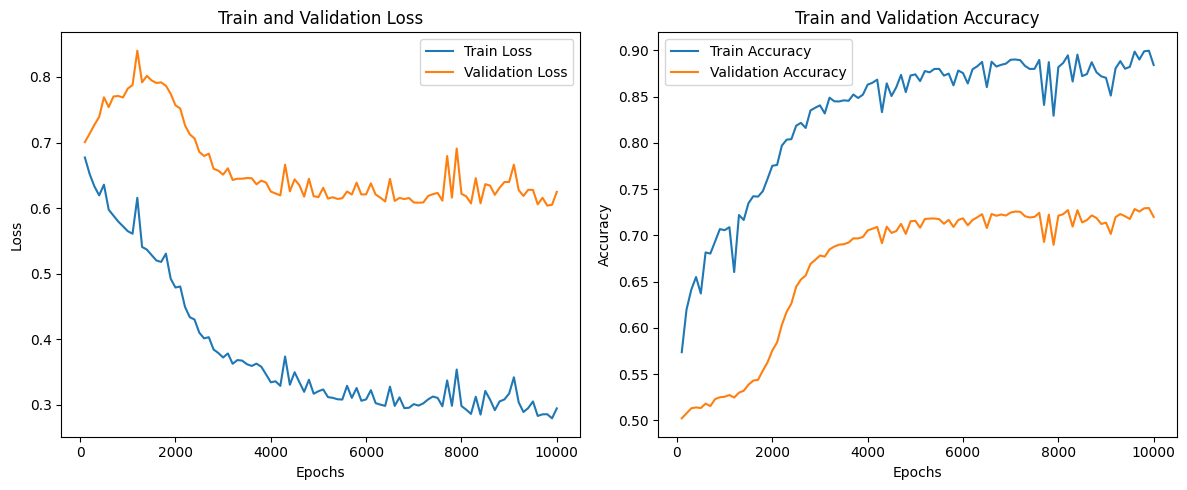

In [18]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs[print_interval - 1::print_interval][:len(train_losses)], train_losses, label="Train Loss")
plt.plot(epochs[print_interval - 1::print_interval][:len(val_losses)], val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs[print_interval - 1::print_interval][:len(train_accuracies)], train_accuracies, label="Train Accuracy")
plt.plot(epochs[print_interval - 1::print_interval][:len(val_accuracies)], val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# check train accuracy
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

net.eval()
with torch.no_grad():  # No gradient calculation during validation
    output_test = net(X_test_tensor)
    _, predicted_test = torch.max(output_test, 1)
    test_accuracy = (predicted_test == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%\n")

Test Accuracy: 71.98%

